In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import glob


In [3]:
def read_in_files(file_path: str=None,
                  f: float=None,
                  time_error: float=None,
                  time_conversion: int=1,
                  B_volts_conversion: int=1,
                  C_volts_conversion: int=1):
    
    """
    This function reads in datafiles csv from a given directory and returns a dataframe with Time, Channel B
    and C voltages and their associated erros.

    Arguments: 
    file_path: The input file_path must be the directory of the folder with a /*.csv extension.
    f: the frequency of the dataset.
    time_error: 1 unit of the last decimal place of the time column. 
    time_conversion: the factor to multiply the time readings by to convert the column into seconds
    B_volts_conversion: the factor to multiply the channel B voltage readings by to convert the column into volts
    C_volts_conversion: the factor to multiply the channel C voltage readings by to convert the column into volts

    Returns: 
    A dataframe with Time, Channel B and C voltages and their associated erros.
    """
    
    # Path to your CSV files (adjust this path to your actual file location)
    csv_files = glob.glob(file_path)

    # Initialize lists to accumulate values for averaging
    channel_b_sum = None
    channel_c_sum = None
    channel_b_sq_dev_sum = None
    channel_c_sq_dev_sum = None
    time_column = None

    # Iterate over each CSV file
    for i, file in enumerate(csv_files):
        # Read each file
        df = pd.read_csv(file)

        # Remove rows indexed at 1 and 2 as they are empty. 
        df.drop([0,1], inplace=True)
        # And reset the index for clarity
        df.reset_index(drop=True, inplace=True)

        # Convert all string values to numerical values
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Extract "Time (ms)", "Channel B (mV)", and "Channel C (mV)" columns
        time_column = df['Time'] * time_conversion  # Convert Time from ms to seconds (only needs to be done once)

        channel_b = df['Channel B'] * B_volts_conversion  # Convert from mV to V
        channel_c = df['Channel C'] * C_volts_conversion  # Convert from mV to V

        # Accumulate the values for averaging
        if channel_b_sum is None:
            channel_b_sum = channel_b
            channel_c_sum = channel_c
        else:
            channel_b_sum += channel_b
            channel_c_sum += channel_c

    # Calculate the averages by dividing by the number of files
    channel_b_avg = channel_b_sum / len(csv_files)
    channel_c_avg = channel_c_sum / len(csv_files)

        # Second pass: Calculate the squared deviations for standard deviation
    for file in csv_files:
        # Read each file
        df = pd.read_csv(file)

        # Remove rows indexed at 1 and 2 as they are empty. 
        df.drop([0,1], inplace=True)
        # And reset the index for clarity
        df.reset_index(drop=True, inplace=True)

        # Convert all string values to numerical values
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Convert from mV to V
        channel_b = df['Channel B'] * B_volts_conversion
        channel_c = df['Channel C'] * C_volts_conversion
        
        # Accumulate the squared deviations from the mean
        if channel_b_sq_dev_sum is None:
            channel_b_sq_dev_sum = (channel_b - channel_b_avg) ** 2
            channel_c_sq_dev_sum = (channel_c - channel_c_avg) ** 2
        else:
            channel_b_sq_dev_sum += (channel_b - channel_b_avg) ** 2
            channel_c_sq_dev_sum += (channel_c - channel_c_avg) ** 2

    # Calculate the standard deviation by taking the square root of the average squared deviation
    # then divide through by sqrt of len(csv_files) to convert this to a standard error. 
    channel_b_std = np.sqrt(channel_b_sq_dev_sum / len(csv_files))/np.sqrt(len(csv_files))
    channel_c_std = np.sqrt(channel_c_sq_dev_sum / len(csv_files))/np.sqrt(len(csv_files))

    # Combine the results into a single DataFrame with the time column
    result_df = pd.DataFrame({
        'Time (s)': time_column,
        'Channel B Average (V)': channel_b_avg,
        'Channel B Average Error (V)': channel_b_std,
        'Channel C Average (V)': channel_c_avg,
        'Channel C Average Error (V)': channel_c_std
    })

    # Need to add an error on the time in (s)
    time_error_column = pd.Series([time_error * time_conversion] * len(result_df))
    result_df.insert(1, 'Time Error (s)', time_error_column)

    # Now extract the element of the dataset which implies the voltage output from 
    # channel C is a 'maximum' to 'maximum' curve. 
    C_amplitude = result_df['Channel C Average (V)'].values

    # Find the peaks, the minimum distance between them should be taken as 
    # ~90% of the number of data points ideally between maxima.
    time_array = np.array(result_df['Time (s)'])
    time_diff = time_array[1] - time_array[0]
    data_points_separating = (1/(f*time_diff))*0.9
    peaks, _ = find_peaks(C_amplitude, distance=data_points_separating)

    df_segment = result_df.iloc[peaks[0]: peaks[1]]
    df_segment.reset_index(drop=True, inplace=True)

    return df_segment


In [4]:
# Testing the read in function: 
test_df = read_in_files(file_path="/Users/student/Library/CloudStorage/OneDrive-DurhamUniversity/Team project/TeamRepo/TeamProject-1/data_sets/*.csv",
                        f=50,
                        time_error=0.001, # This should be in the units which your original time column is in, the conversion is accounted for in the code
                        time_conversion=1e-3,
                        B_volts_conversion=1,
                        C_volts_conversion=1)

In [5]:

# Create a function which will compute the error on the product of 2 variables 
def error_multi_product(A: np.array=None,
                        alpha_A: np.array=None,
                        B: np.array=None,
                        alpha_B: np.array=None) -> np.array:
    """
    This function calculates the error on the product of 2 variables A and B
    """

    return (A*B) * np.sqrt((alpha_A/A)**(2) + (alpha_B/B)**(2))


In [6]:
# Create a function which will compute the error on the quotient of 2 variables 
def error_multi_quotient(A: np.array=None,
                         alpha_A: np.array=None,
                         B: np.array=None,
                         alpha_B: np.array=None) -> np.array:
    """
    This function calculates the error on the quotient of 2 variables A/B.
    """

    return (A/B) * np.sqrt((alpha_A/A)**(2) + (alpha_B/B)**(2))

In [131]:
def replace_fractional_error(df: pd.DataFrame,
                            column_name: str=None,
                            column_error_name: str=None,
                            max_fractional_error: float=0.7):
    
    # Calculate a fractional error array 
    fractional_error = df[column_error_name]/df[column_name]

    # Identify rows where the fractional error exceeds the max_fractional_error
    exceeds_cap = abs(fractional_error) > max_fractional_error

    # Replace the errors that exceed the cap with capped values
    # Capped error = max_fractional_error * value
    df.loc[exceeds_cap, column_error_name] = max_fractional_error * df.loc[exceeds_cap, column_name]

    return df



In [132]:
# Test the function: 
data = {
    'value': [10, 20, 30, 40, 50],
    'error': [2, 5, 20, 1, 30]  # Errors associated with the values
}

df=pd.DataFrame(data)

final_df = replace_fractional_error(df=df,
                         column_name='value',
                         column_error_name='error',
                         max_fractional_error=0.5)

print(final_df)



   value  error
0     10      2
1     20      5
2     30     15
3     40      1
4     50     25


In [137]:

# We can create a function which calculates both B and H: 
def B_H_calculation(df: pd.DataFrame=None,
                          time_column: str=None,
                          time_error_column: str=None,
                          voltage_column: str=None,
                          voltage_error_column: str=None,
                          voltage_current_column: str=None,
                          voltage_current_error_column: str=None,
                          V_0: float=None,
                          V_0_error: float=None,
                          N_2: int=None,
                          N_1: int=None,
                          A: float=None,
                          A_error: float=None,
                          R: float=None,
                          R_error: float=None,
                          l: float=None,
                          l_error: float=None,) -> pd.DataFrame:
    """
    This function takes in the dataframes defiend by read_in_files, and returns a dataframe with 
    columns of integrated voltage, its error, the B-field, its error and the H-field and its error.

    Arguments: 
    df: The data frame which contains the initial (x,y') points to be integrated
    time_column: the name of the column which contains the time data
    time_error_column: the name of the column which contains the error on the time
    voltage_column: the name of the column which contains the voltage data from the secondary coil
    voltage_error_column: the name of the column which contains the error on the averaged voltage from the secondary coil 
    voltage_current_column: the name of the column which contains the voltage data to be converted to current 
    voltage_current_error_column: the name of the column which contains the error on the averaged voltages to be 
    converted to current.
    V_0: the initial value of the integral of the voltage.
    V_0_error: the error on the initial value of V_0
    N_2: the number of turns on the secondary coil
    A: Area of the coil in m^(2)
    A_error: Error on the area (m^(2))
    R: the resistance of the resistor
    R_error: the error on the resitance of the resistor
    l: The magnetic path length (m)
    l_error: The error on the magnetic path length (m)

    Returns: 
    The same pandas dataframe with columns of integrated voltage, its error, the B-field, its error and
    the H-field and its error.
    """  

    # Just take out the x_vlaues (this is just used for length calculations)
    x_values = df[time_column]

    # Define a numpy array to hold the integral values 
    integral_value = np.zeros(len(x_values))
    # Assign the first value of the time integral of the voltage at t=0.
    integral_value[0] = V_0

     # Create a copy of the dataframe to insert the integrated voltage, B-field and H-filed columns to
    df_to_ret = df.copy()

    # Now add an 'integrated' column to the copy of the dataframe
    df_to_ret['Integrated Voltage (Vs)'] = cumulative_trapezoid(df[voltage_column], df[time_column], initial=V_0)

    # Now we want to calculate the errors on the B-field. This must be done in parts.
    # We will calculate the errors on each Integrated Voltage (Vs) which is int V_1 and beyond. int V_0's error is pre-defined by the user. 

    # Compute the sum of each (V_{i-1} + V_{i})/2:
    voltage_sums_2 = np.array(df_to_ret[voltage_column][1:] + np.array(df_to_ret[voltage_column][:-1]))/2

    # Take out the Average Voltage Error from the dataframe and store it as a numpy array
    average_voltage_error = np.array(df_to_ret[voltage_error_column])
    # Create a numpy array to hold the errors on the sums of the voltages, this should be of length x_values - 1. 
    voltage_sum_error = np.sqrt(average_voltage_error[1:]**(2) + average_voltage_error[:-1]**(2))
    
    # The error on the voltage sum divided by 2 is then:
    voltage_sum_error_2 = voltage_sum_error/2

    # Replace all NaN values with 0.
    voltage_sum_error_2 = np.nan_to_num(voltage_sum_error_2, nan=0)

    # Compute the difference in the time values and make it an array of length(x-1).
    time_diff = df_to_ret[time_column][1] - df_to_ret[time_column][0]
    time_diff = np.full(len(x_values) - 1, time_diff)
    
    # the error on the time difference will be the same for each error in the integrated voltage:
    alpha_time_diff = np.sqrt(2*(df_to_ret[time_error_column][0])**(2))
    time_diff_error = np.full(len(x_values) - 1, alpha_time_diff)

    # Now we need the error on the product of the sum of the voltages and the time difference, made modulus:
    product_voltage_time_diff_error = abs(error_multi_product(A=voltage_sums_2, alpha_A=voltage_sum_error_2, B=time_diff, alpha_B=time_diff_error))

    # Calculate the errors on the integrated voltage and beyond
    integrated_voltage_err = np.zeros(len(x_values))
    # Assign the first error to that inputted to the function:
    differences_IV = np.abs(np.diff(df_to_ret['Integrated Voltage (Vs)']))
    max_difference = np.max(differences_IV)/50

    integrated_voltage_err[0] = np.abs(max_difference)

    # Now calculate the remaining: 
    for i in range(1, len(x_values)):
        integrated_voltage_err[i] = np.sqrt((integrated_voltage_err[i-1])**(2) + (product_voltage_time_diff_error[i-1])**(2))

    df_to_ret['Integrated Voltage Error (Vs)'] = np.abs(integrated_voltage_err)
    
    # Add a column for the B filed
    df_to_ret['B Field (T)'] = df_to_ret['Integrated Voltage (Vs)']/(N_2*A)

    # Compute the error on the B field
    B_field_error = error_multi_quotient(A=np.array(df_to_ret['Integrated Voltage (Vs)']), 
                                        alpha_A=np.array(df_to_ret['Integrated Voltage Error (Vs)']),
                                        B = A,
                                        alpha_B = A_error)/N_2

    # Add an error on the B fieled column
    df_to_ret['B Field Error (T)'] = np.abs(B_field_error)

    # Now we want to compute the H-field and its error. 
    # We need to obtain the current using a resistance and voltage: 
    df_to_ret['Current (A)'] = df_to_ret[voltage_current_column]/R

    # The error on the current will be given using the quotient rule above:
    df_to_ret['Current Error (A)'] = np.abs(error_multi_quotient(A=df_to_ret[voltage_current_column],
                                                          alpha_A=df_to_ret[voltage_current_error_column],
                                                          B=np.full(len(x_values), R),
                                                          alpha_B=np.full(len(x_values), R_error)))

    # The H field itself if the product of the current and number of turns on the primary coil,
    # divided by the magnetic path length (l). 
    df_to_ret['H Field (H)'] = df_to_ret['Current (A)'] * N_1/l

    # To obtain the error on the H filed, we will use the quotient rule above (which considers the error
    # on l and I). This will then be multiplied by N_1: 
    df_to_ret['H Field Error (H)'] = np.abs(N_1 * error_multi_quotient(A=df_to_ret['Current (A)'],
                                                                alpha_A=df_to_ret['Current Error (A)'],
                                                                B=np.full(len(x_values), l),
                                                                alpha_B=np.full(len(x_values), l_error)))
    
    df_to_ret = replace_fractional_error(df=df_to_ret, column_name='Integrated Voltage (Vs)', column_error_name='Integrated Voltage Error (Vs)', max_fractional_error=1)
    df_to_ret = replace_fractional_error(df=df_to_ret, column_name='B Field (T)', column_error_name='B Field Error (T)', max_fractional_error=1) 
    df_to_ret = replace_fractional_error(df=df_to_ret, column_name='H Field (H)', column_error_name='H Field Error (H)', max_fractional_error=1)
    return df_to_ret

/var/folders/9g/cjhg798d7tv3p38jl4nrwggr0000gn/T/ipykernel_2086/2849966238.py:10: RuntimeWarning: divide by zero encountered in divide
  return (A/B) * np.sqrt((alpha_A/A)**(2) + (alpha_B/B)**(2))
/var/folders/9g/cjhg798d7tv3p38jl4nrwggr0000gn/T/ipykernel_2086/2849966238.py:10: RuntimeWarning: invalid value encountered in multiply
  return (A/B) * np.sqrt((alpha_A/A)**(2) + (alpha_B/B)**(2))


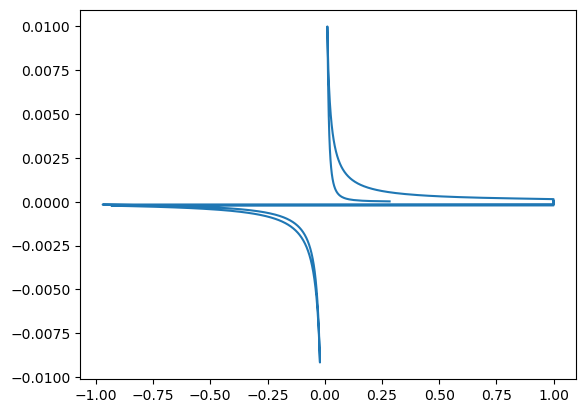

In [138]:
result_df = B_H_calculation(df=test_df,
                            time_column='Time (s)',
                            time_error_column='Time Error (s)',
                            voltage_column='Channel C Average (V)',
                            voltage_error_column='Channel C Average Error (V)',
                            voltage_current_column='Channel B Average (V)',
                            voltage_current_error_column='Channel B Average Error (V)',
                            V_0=0,
                            N_2=5,
                            N_1=5,
                            A=8.93e-4,
                            A_error=1e-10,
                            R=0.6,
                            R_error=0.001,
                            l=0.325,
                            l_error=0.01)

plt.plot(result_df['Integrated Voltage Error (Vs)']/result_df['Integrated Voltage (Vs)'] ,result_df['Integrated Voltage (Vs)'])


In [153]:
# Now we will want to plot the BH Curve and calculate the area between itn
def B_H_plotter(df: pd.DataFrame=None,
                show: bool=True) -> tuple:
    
    """
    This function plots a BH curve with error bars and calculates the area inside the curve 
    and the error on it. 

    Parameters: 
    df: the input dataframe, this is from the B_H calculation function above
    show: a boolean that determines if the plot should be shown or not. Default is True.
    The column names regrading B and H and their associated errors are fixed for this dataframe

    Returns:
    A tuple: (hysteresis loss, error on hysteresis loss)
    """

    # Create a figure and axis: 
    fig, ax = plt.subplots()

    # Plot the B vs H using a plt.scatter curve? 
    ax.errorbar(df['H Field (H)'],
                df['B Field (T)'],
                xerr=abs(df['H Field Error (H)']),
                #yerr=abs(df['B Field Error (T)']),
                ecolor='grey',
                alpha=0.6,
                capsize=3,
                capthick=1,
    )
    
    # Add x and y labels
    ax.set_xlabel('Magnetic Field Strength ($Am^{-1}$)')

    ax.set_ylabel('Magnetic Flux Density (T)')

    # Show the plot if the user would like
    if show: 
        plt.show()

    # Now calculate the area underneath the curve. We can use the same
    # Trapezium rule as before for this: 
    core_loss = np.abs(np.trapz(df['B Field (T)'], df['H Field (H)']))

    # Now calculate the error on the core losses: 
    # convert each of the B and H columns to np arrays which are more flexible
    B_field = np.array(df['B Field (T)'])
    B_field_error = abs(np.array(df['B Field Error (T)']))
    H_field = np.array(df['H Field (H)'])
    H_field_error = abs(np.array(df['H Field Error (H)']))


    # Create an initial array for the error on the area of each trapezoid
    trapezoid_errors = np.zeros(len(B_field) - 1)

    # Create an array of H diff and H diff errors, and a trapezoid area array
    trapezoid_areas = np.zeros(len(B_field)-1)

    # Iterate over each trapezoid
    for i in range(len(B_field) - 1):
        # Calculate the error in the B field sums divided by 2:
        B_sum_error_2 = np.sqrt(B_field_error[i]**2 + B_field_error[i+1]**2) / 2
        
        # Calculate the error on the difference of the H fields:
        H_diff_error = np.sqrt(H_field_error[i]**2 + H_field_error[i+1]**2)

        # Ensure that the trapezoid area is positive, by using absolute differences
        B_avg = np.abs((B_field[i] + B_field[i+1]) / 2)
        H_diff = np.abs(H_field[i+1] - H_field[i])  # Use absolute difference here

        # Calculate the trapezoid area
        trapezoid_area = (np.abs(B_field[i]) + np.abs(B_field[i+1])) * H_diff / 2
        trapezoid_areas[i] = trapezoid_area

        if H_diff_error/H_diff > 0.1:
            H_diff_error = 0.1 * H_diff 
        if B_sum_error_2/B_avg > 0.1:
            B_sum_error_2 = B_avg * 0.1

        # Calculate the total propagated error using Hughes and Hase formula
        trapezoid_errors[i] = trapezoid_area * np.sqrt(
            (B_sum_error_2 / B_avg)**2 + (H_diff_error / H_diff)**2
        )
    
    trapezoid_errors = np.nan_to_num(trapezoid_errors, nan=0.0)

    total_error = np.sqrt(np.sum(trapezoid_errors**2))

    return (core_loss, total_error)
    
    

(241.79024081767946, 4.103861260205102)


/var/folders/9g/cjhg798d7tv3p38jl4nrwggr0000gn/T/ipykernel_2086/1681417842.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  if H_diff_error/H_diff > 0.1:
/var/folders/9g/cjhg798d7tv3p38jl4nrwggr0000gn/T/ipykernel_2086/1681417842.py:82: RuntimeWarning: invalid value encountered in scalar divide
  (B_sum_error_2 / B_avg)**2 + (H_diff_error / H_diff)**2


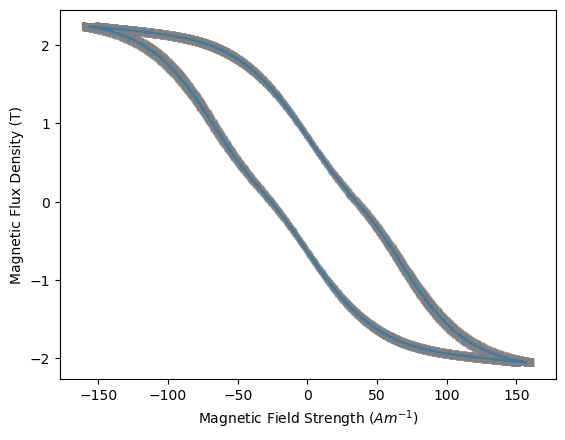

In [154]:
# The mean trapezoid error is 36.1696, where as the mean area itself is 0.46814...
# this is bad. We need to reduce the fractional error of H. 
values = B_H_plotter(df=result_df,
                     show=False)

print(values)




